In [18]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [5]:
## max length for comment
## you can use the maximum length found after reading in entire dataset
## or you can use histogram and find length that covers most of dataset
MAX_SEQUENCE_LENGTH = 100
## this is based on research saying native speakers know 20000 words but who knows
MAX_VOCAB_SIZE = 20000
## size of each word vector usually preset if using already trained hyperparameters
EMBEDDING_DIM = 100;
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [6]:
## loading in the text file and creating a dictionary from word to word vector
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('work_embedding/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec=np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [7]:
print('Loading in comments...')
train = pd.read_csv('data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values;

Loading in comments...


In [8]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length: ', s[len(s) // 2])

max sequence length:  5000
min sequence length:  6
median sequence length:  205


In [9]:
## Converts sentences from strings to integer representations (for each letter)
## Turn sentences into list of tokens and convert tokens into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
## fit_on_texts creates/updates vocabulary index dictionary based on word frequency
## More frequent words in the argument will give lower integer
tokenizer.fit_on_texts(sentences)
## transforms the text in the argument into integer using vocabulary index dictionary
## created from fit_on_texts
sequences = tokenizer.texts_to_sequences(sentences)

In [10]:
# maps word to index
word2idx = tokenizer.word_index
print('Found %s unique tokens' % len(word2idx))

Found 210337 unique tokens


In [11]:
# note how after tokenizer the number for each sequence is still different
# here we will pad the sequences to make sure they are all same length
# note this is preset to 100 even though median is 200 lol
# note this pads with 0 which is the dummy value for the word2idx dictionary
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [12]:
print('Filling pre-trained embeddings...')
# no point being bigger than number of words in word2idx cause..pointless
# +1 because keras starts at 1, so to use 20000
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# iterator through (key, value) pairs in dict
# this will generate an embedding layer where each layer is word2idx
# word (so most common goes on top in the layer) but translated to vector
# form using pre-trained embedding vector from glove
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        # using get here to prevent exception if word not found
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # a vector of all zeroes = words not found in embedding vector (pre-trained stuff)
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
# load pre-trained word embeddings into embedding layer
# trainable = False to keep embedding fixed during BP
# Visualize how one hot encoding [0,0,0,0,....1,....0]
# will point to one of the word's vector based representation
# from the pre-trained gloves
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [15]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
## GlobalMaxPooling will look for the max value over all time
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 15)           6960      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 2,007,056
Trainable params: 7,056
Non-trainable params: 2,000,000
_________________________________________________________________


In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 55s 427us/step - loss: 0.1445 - accuracy: 0.9612 - val_loss: 0.0871 - val_accuracy: 0.9725
Epoch 2/10
127656/127656 [==============================] - 53s 417us/step - loss: 0.0776 - accuracy: 0.9741 - val_loss: 0.0719 - val_accuracy: 0.9753
Epoch 3/10
127656/127656 [==============================] - 53s 418us/step - loss: 0.0670 - accuracy: 0.9771 - val_loss: 0.0650 - val_accuracy: 0.9774
Epoch 4/10
127656/127656 [==============================] - 53s 412us/step - loss: 0.0619 - accuracy: 0.9786 - val_loss: 0.0622 - val_accuracy: 0.9781
Epoch 5/10
127656/127656 [==============================] - 53s 416us/step - loss: 0.0591 - accuracy: 0.9796 - val_loss: 0.0595 - val_accuracy: 0.9792
Epoch 6/10
127656/127656 [==============================] - 53s 412us/step - loss: 0.0569 - accuracy: 0.9801 - val_loss: 0.0582 - val_accuracy: 0.9795
Epoch 7/10
127656/127656 [=================

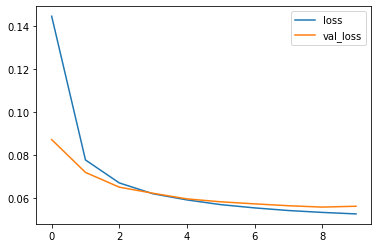

In [19]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

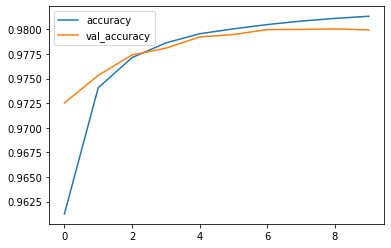

In [20]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [21]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc=roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.970537028067867
